Let's cluster the samples in the SwissProt GO dataset by their GO terms so we can use the cluster assignment to later do a stratified train/test split. We'll start by creating some embeddings for the terms.

Dimensionality: 512, Explained Variance: 0.7981


Clustering All
Initialization 0
  Iteration 10	 time lapse 9.13001s	 ll change 1.12886
  Iteration 20	 time lapse 6.13074s	 ll change 0.20140
  Iteration 30	 time lapse 5.92467s	 ll change 0.17936
  Iteration 40	 time lapse 5.95446s	 ll change 0.12739
  Iteration 50	 time lapse 5.73956s	 ll change 0.16362
  Iteration 60	 time lapse 5.91414s	 ll change 0.27916
  Iteration 70	 time lapse 5.72869s	 ll change 0.02277
  Iteration 80	 time lapse 5.75891s	 ll change 0.00762
  Iteration 90	 time lapse 5.67162s	 ll change 0.02427
  Iteration 100	 time lapse 5.80478s	 ll change 0.00808
  Iteration 110	 time lapse 5.62730s	 ll change 0.01157
  Iteration 120	 time lapse 5.89685s	 ll change 0.00654
  Iteration 130	 time lapse 5.67472s	 ll change 0.00413
  Iteration 140	 time lapse 5.96131s	 ll change 0.00173
  Iteration 150	 time lapse 5.76001s	 ll change 0.00108
Initialization converged. time lapse 95.32699s	 lower bound 438.13145.




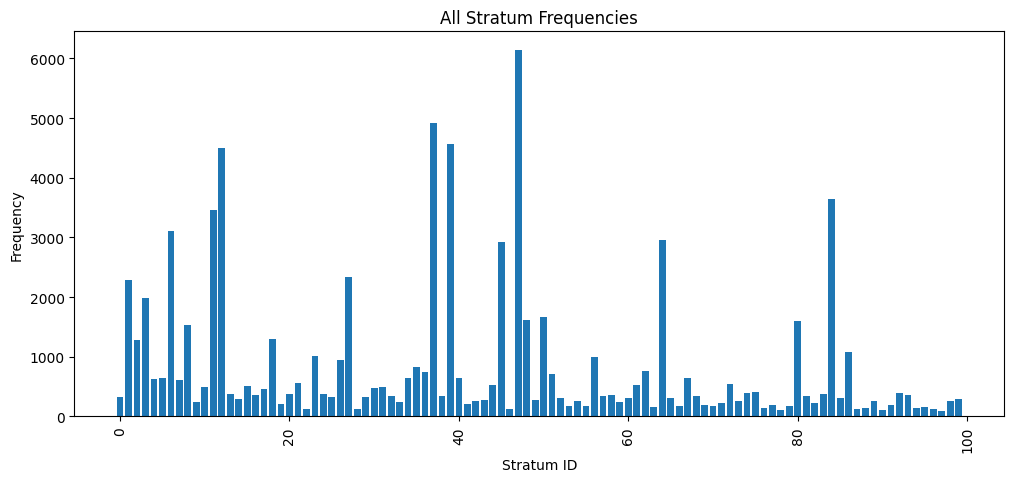



Dimensionality: 256, Explained Variance: 0.8449


Clustering Molecular Function
Initialization 0
  Iteration 10	 time lapse 3.46717s	 ll change 1.33143
  Iteration 20	 time lapse 2.75129s	 ll change 0.03347
  Iteration 30	 time lapse 2.85686s	 ll change 0.03458
  Iteration 40	 time lapse 2.90064s	 ll change 0.02883
Initialization converged. time lapse 13.27807s	 lower bound 505.60718.




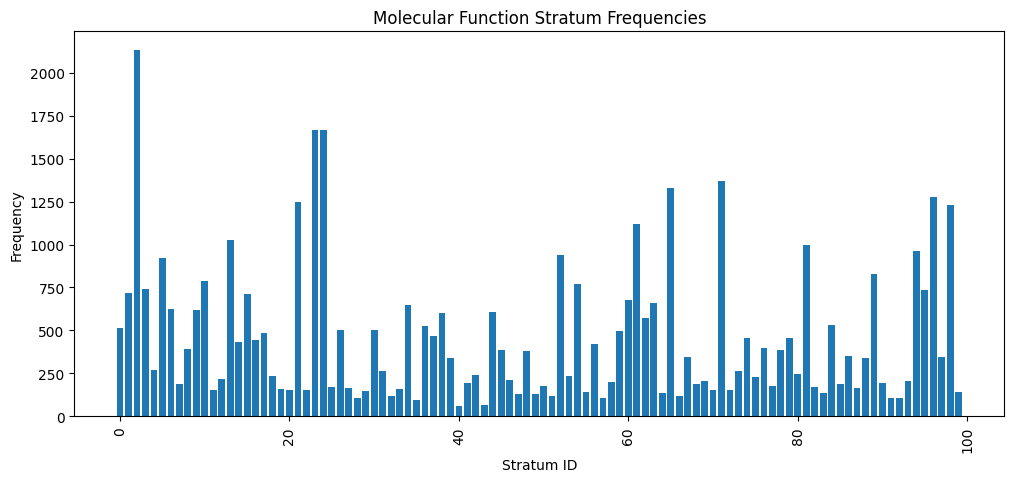



Dimensionality: 512, Explained Variance: 0.8249


Clustering Biological Process
Initialization 0
  Iteration 10	 time lapse 7.34839s	 ll change 0.88728
  Iteration 20	 time lapse 4.62870s	 ll change 0.16887
  Iteration 30	 time lapse 4.47671s	 ll change 0.10785
  Iteration 40	 time lapse 4.68464s	 ll change 0.06156
  Iteration 50	 time lapse 4.52633s	 ll change 0.11124
  Iteration 60	 time lapse 4.48161s	 ll change 0.01588
  Iteration 70	 time lapse 4.48559s	 ll change 0.01929
  Iteration 80	 time lapse 4.60672s	 ll change 0.15449
  Iteration 90	 time lapse 4.27542s	 ll change 0.01981
  Iteration 100	 time lapse 4.34818s	 ll change 0.01960
  Iteration 110	 time lapse 4.45133s	 ll change 0.05884
  Iteration 120	 time lapse 4.51682s	 ll change 0.00148
Initialization converged. time lapse 58.14166s	 lower bound 450.11298.




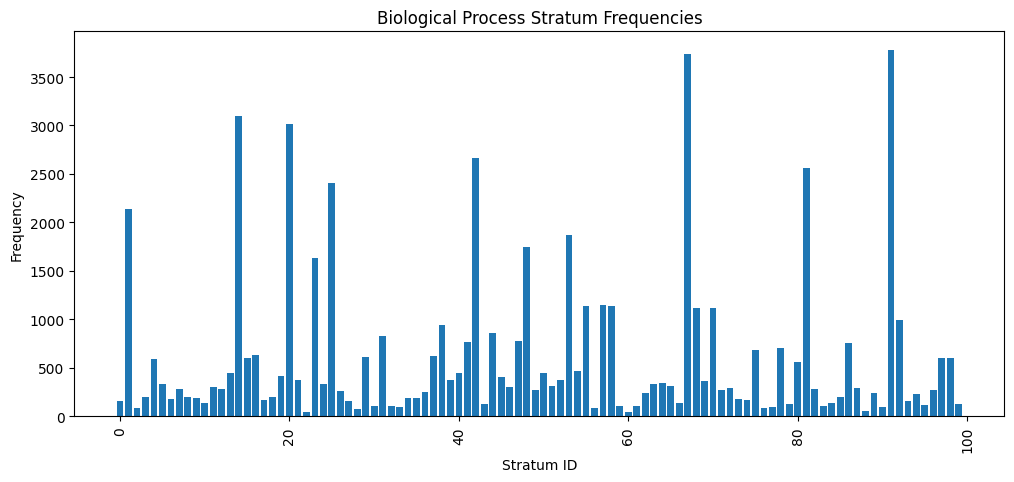



Dimensionality: 128, Explained Variance: 0.8888


Clustering Cellular Component
Initialization 0
  Iteration 10	 time lapse 3.19245s	 ll change 0.31812
  Iteration 20	 time lapse 2.64721s	 ll change 0.07096
  Iteration 30	 time lapse 2.68180s	 ll change 0.01534
  Iteration 40	 time lapse 2.69661s	 ll change 0.00063
Initialization converged. time lapse 11.21818s	 lower bound 330.63380.




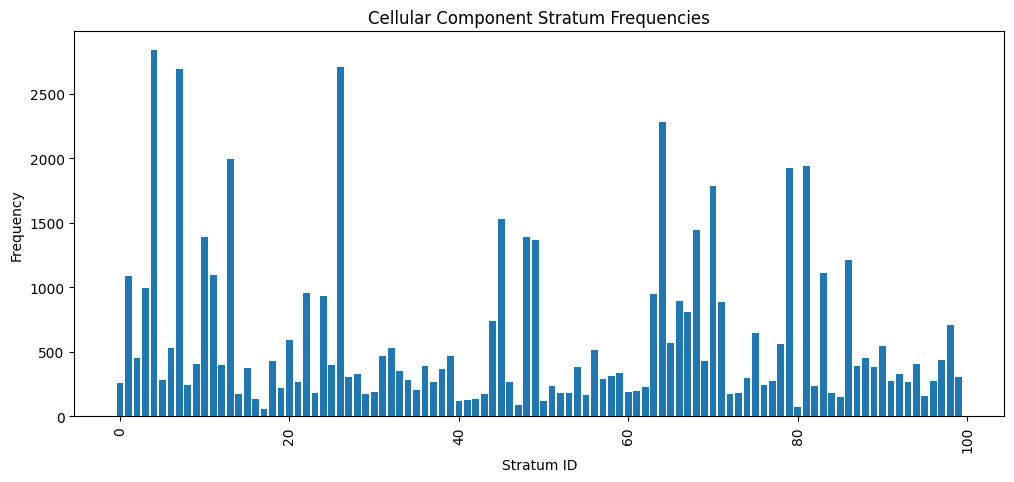

In [3]:
from functools import partial

from datasets import load_dataset

import numpy as np

from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture

from collections import Counter

import matplotlib.pyplot as plt

all_dataset_path = "./dataset/all-expanded.jsonl"
mf_dataset_path = "./dataset/mf-expanded.jsonl"
bp_dataset_path = "./dataset/bp-expanded.jsonl"
cc_dataset_path = "./dataset/cc-expanded.jsonl"

num_strata = 100

random_seed = 42

all_stratum_ids = {}
mf_stratum_ids = {}
bp_stratum_ids = {}
cc_stratum_ids = {}

new_svd = partial(TruncatedSVD, random_state=random_seed)

new_gmm = partial(
    GaussianMixture,
    n_components=100,
    covariance_type="diag",
    random_state=random_seed,
    max_iter=300,
    verbose=2,
)

all_counter = Counter()
mf_counter = Counter()
bp_counter = Counter()
cc_counter = Counter()

for name, dataset_path, stratum_ids, dimensions, counter in [
    ("All", all_dataset_path, all_stratum_ids, 512, all_counter),
    ("Molecular Function", mf_dataset_path, mf_stratum_ids, 256, mf_counter),
    ("Biological Process", bp_dataset_path, bp_stratum_ids, 512, bp_counter),
    ("Cellular Component", cc_dataset_path, cc_stratum_ids, 128, cc_counter),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    unique_terms = set()

    for record in dataset:
        for term in record["go_terms"]:
            unique_terms.add(term)

    term_index_mapping = {term: index for index, term in enumerate(unique_terms)}

    term_embeddings = {}

    for record in dataset:
        id = record["id"]

        embedding = np.zeros(len(term_index_mapping), dtype=np.int8)

        for term in record["go_terms"]:
            if term in term_index_mapping:
                index = term_index_mapping[term]

                embedding[index] = 1

        term_embeddings[id] = embedding

    svd = new_svd(n_components=dimensions)

    x = np.stack(list(term_embeddings.values()))
    
    svd.fit(x)
    
    explained_variance = np.sum(svd.explained_variance_ratio_)

    print(f"Embedding dimensionality: {dimensions}, Explained Variance: {explained_variance:.4f}")

    z = svd.transform(x)

    for sequence_id, embedding in zip(term_embeddings.keys(), z):
        term_embeddings[sequence_id] = embedding

    print("\n")

    gmm = new_gmm()

    x = np.stack(list(term_embeddings.values()))

    predictions = gmm.fit_predict(x)

    for sequence_id, stratum_id in zip(term_embeddings.keys(), predictions):
        stratum_ids[sequence_id] = stratum_id

        counter[stratum_id] += 1

    plt.figure(figsize=(12, 5)) 

    plt.bar(counter.keys(), counter.values())

    plt.title(f"{name} Stratum Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("Stratum ID")
    plt.ylabel("Frequency")

    plt.show()

    print("\n")

Lastly, add the term embeddings and stratum IDs to the dataset and write to disk.

In [4]:
import json

all_stratified_path = "./dataset/all-stratified.jsonl"
mf_stratified_path = "./dataset/mf-stratified.jsonl"
bp_stratified_path = "./dataset/bp-stratified.jsonl"
cc_stratified_path = "./dataset/cc-stratified.jsonl"

for dataset_path, stratified_path, stratum_ids, counter in [
    (all_dataset_path, all_stratified_path, all_stratum_ids, all_counter),
    (mf_dataset_path, mf_stratified_path, mf_stratum_ids, mf_counter),
    (bp_dataset_path, bp_stratified_path, bp_stratum_ids, bp_counter),
    (cc_dataset_path, cc_stratified_path, cc_stratum_ids, cc_counter),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    dropped = 0

    with open(stratified_path, "w") as file:
        for record in dataset:
            id = record["id"]
            stratum_id = stratum_ids[id]

            if counter[stratum_id] < 2:
                dropped += 1

                continue

            record["stratum_id"] = str(stratum_id)

            file.write(json.dumps(record) + "\n")

    print(f"Dropped {dropped:,} noise samples from dataset.")

    print(f"Dataset saved to {stratified_path}")

print("Done!")

Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/all-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/mf-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/bp-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/cc-stratified.jsonl
Done!
